# Model Performance on Data from Different Sources

In this notebook, we evaluated the cross dataset accuracy of the trained classifiers.

There are 15 different data sources.
For each data source, we trained a classifier using a training sample from the data source.
For evaluation, we use each classifier to predict the labels of 15 new samples from each data sources.
Finally, we organize the model accuracy on each sample sets into a 15x15 matrix.

In [236]:
import pandas as pd
import numpy as np

In [237]:
with open("testing_log_all.log") as f:
    lines = f.readlines()

data = []
i = 0
while i + 2 < len(lines):
    split = lines[i].strip().split()
    model = split[3]
    test = split[6]
    split = lines[i + 2].split(',')
    model_size = int(split[2])
    avg_potential = float(split[3])
    auprc = float(split[4])
    auroc = float(split[5])
    data.append([
        model, test, model_size, avg_potential, auprc, auroc,
    ])
    i += 3

row_pd = pd.DataFrame(data, columns=["model", "data", "model_size", "avg_potential", "auprc", "auroc"])
data_dict = {name: i for i, name in enumerate(row_pd["model"].unique())}
rev_data_dict = {i: name for name, i in data_dict.items()}

In [238]:
mat = np.zeros(shape=(len(data_dict), len(data_dict)))
for index, row in row_pd.iterrows():
    mat[data_dict[row.model]][data_dict[row["data"]]] = row.auroc

mat = np.nan_to_num(mat)

In [239]:
import sys
np.savetxt(sys.stdout, mat, '%1.2f')

1.00 0.00 0.50 0.49 0.22 0.50 0.61 0.39 0.28 0.55 0.67 0.61 0.60 0.69 0.66
0.50 0.00 0.50 0.50 0.50 0.50 0.50 0.50 0.50 0.50 0.50 0.50 0.50 0.50 0.50
0.65 0.00 0.94 0.63 0.70 0.48 0.69 0.54 0.69 0.50 0.23 0.55 0.52 0.61 0.70
0.49 0.00 0.50 1.00 0.92 0.48 0.52 0.39 0.65 0.55 0.57 0.54 0.58 0.45 0.33
0.61 0.00 0.72 0.58 1.00 0.53 0.50 0.63 0.66 0.49 0.86 0.73 0.50 0.71 0.80
0.42 0.00 0.66 0.52 0.86 0.99 0.53 0.66 0.77 0.47 0.58 0.81 0.57 0.73 0.48
0.67 0.00 0.57 0.43 0.79 0.47 0.99 0.55 0.56 0.51 0.21 0.47 0.63 0.56 0.85
0.65 0.00 0.90 0.72 0.95 0.56 0.92 1.00 0.77 0.67 0.67 0.80 0.74 0.77 0.91
0.45 0.00 0.86 0.75 0.96 0.62 0.94 0.63 1.00 0.67 0.29 0.83 0.71 0.73 0.91
0.54 0.00 0.56 0.56 0.83 0.48 0.57 0.78 0.74 1.00 0.20 0.74 0.45 0.74 0.56
0.44 0.00 0.51 0.52 0.69 0.53 0.34 0.51 0.50 0.33 0.98 0.60 0.51 0.55 0.28
0.47 0.00 0.70 0.53 0.90 0.68 0.75 0.66 0.77 0.38 0.71 1.00 0.54 0.67 0.70
0.62 0.00 0.89 0.66 0.90 0.50 0.96 0.36 0.49 0.61 0.19 0.23 1.00 0.71 0.81
0.52 0.00 0.71 0.58 0.95 

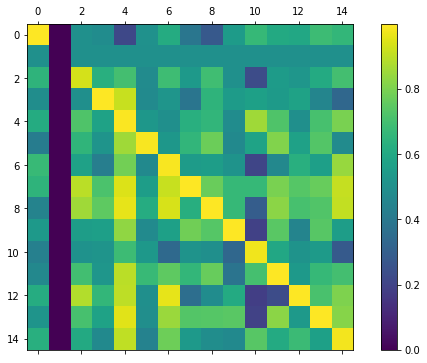

In [240]:
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.matshow(mat.clip(0, 1))
fig.colorbar(cax);

# Simple Hierarchical Clustering

We then use a simple hierarchical clustering algorithm to find the potential "communities" of the data sources. Specifically, we want to find a disjoint partitioning of the data sources, such that the model trained on any data source within the partition can make reasonably good predictions on the data samples from a different data source in its partition.

In [242]:
order = []
for i in range(mat.shape[0]):
    for j in range(i + 1, mat.shape[1]):
        order.append((max(mat[i][j], mat[j][i]), (i, j)))
order = sorted(order, reverse=True)

In [243]:
prt = [i for i in range(mat.shape[0])]
tree_nodes = {i: i for i in range(mat.shape[0])}
tree_count = mat.shape[0]

def find_prt(i):
    global prt
    if i == prt[i]:
        return i
    prt[i] = find_prt(prt[i])
    return prt[i]

for _, (i, j) in order:
    find_prt(i)
    find_prt(j)
    if prt[i] == prt[j]:
        continue
    tree_nodes[tree_count] = (tree_nodes[prt[i]], tree_nodes[prt[j]])
    del tree_nodes[prt[i]]
    del tree_nodes[prt[j]]
    prt[prt[i]] = tree_count
    prt[prt[j]] = tree_count
    assert(len(prt) == tree_count)
    prt.append(tree_count)
    tree_count += 1
hier = list(tree_nodes.values())
assert(len(hier) == 1)


def shuffle_right(tree):
    assert(type(tree) != tuple or len(tree) == 2)
    if type(tree) != tuple:
        return (tree, 1)
    left_tree, left_size = shuffle_right(tree[0])
    righ_tree, righ_size = shuffle_right(tree[1])
    total = left_size + righ_size
    if left_size < righ_size:
        return ((left_tree, righ_tree), total)
    return ((righ_tree, left_tree), total)

tree, _ = shuffle_right(hier[0])
print("The tree structure:", tree)

The tree structure: (1, (0, (9, (5, (10, (2, (11, (14, (3, ((12, 6), (7, (13, (8, 4)))))))))))))


In [244]:
def map_to_source(tree):
    assert(type(tree) != tuple or len(tree) == 2)
    if type(tree) != tuple:
        return rev_data_dict[tree]
    left_tree = map_to_source(tree[0])
    righ_tree = map_to_source(tree[1])
    return (left_tree, righ_tree)

map_to_source(tree)

('lakes',
 ('NGA',
  ('DGBR',
   ('NOAA',
    ('NAVO',
     ('GEOMAR',
      ('IFREMER',
       ('IBCAO',
        ('JAMSTEC',
         (('AGSO', 'CCOM'), ('US', ('NGDC', ('SIO', 'GEBCO')))))))))))))

Since AUROC belows 0.5 is worse than random guessing, in the visualization below we substract 0.5 from the AUROC value and cap it above 0.0, namely set the accuracy as `max(AUROC - 0.5, 0)`.

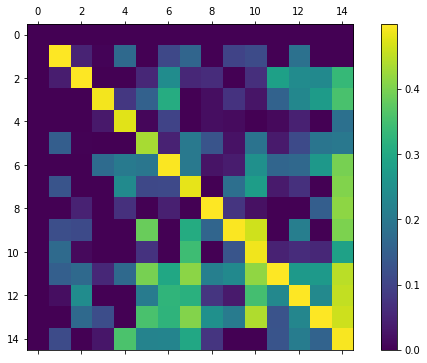

In [245]:
def flatten(tree):
    assert(type(tree) != tuple or len(tree) == 2)
    if type(tree) != tuple:
        return [tree]
    return flatten(tree[0]) + flatten(tree[1])

shuffle = flatten(tree)
shuffle_mat = np.empty_like(mat)
for i in range(mat.shape[0]):
    shuffle_mat[i] = mat[i][shuffle]
shuffle_mat = shuffle_mat[shuffle]

fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.matshow((shuffle_mat - 0.5).clip(0.0))
fig.colorbar(cax);

# Data sources

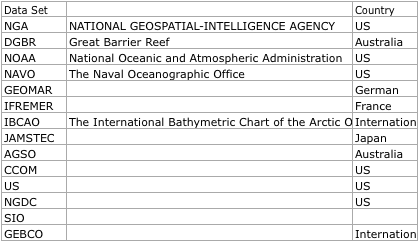